# Predicting Work Placement Status using Academic Percentages
DSCI 100 Project Report \
**Group 005-32**: Imanjosh Chahal, Kahsennaró-roks Deom, Romina Mahinpei

## I. Introduction

For students, getting a work placement is of great concern. Many students work on obtaining high academic averages so that they can be recognized by employers and ultimately secure a work placement. Seeing this cycle, we formed the following research question: **can we predict whether an employer will hire students based on their secondary school, high school, and undergrad degree acedemic percentages?** We aim to answer this question using a classifier trained by the K-nearest neighbours (KNN) algorithm with the dataset described below.

Our chosen dataset was collected by Jain University and published on Kaggle [1]. The dataset contains 215 observations and 15 variables. This project only considers 6 out of the 15 variables and does not use the 9 remaining categorical variables. Our target variable is status of placement (denoted as status in the dataset), indicating whether a student received a work placement position or not. Our potential predictors included secondary school, high school, undergrad degree, MBA degree, and employability test percentages (denoted as ssc_p, hsc_p, degree_p, mba_p, etest_p respectively in the dataset). However, after eliminating potential irrelevant predictors as later described, our final predictors include secondary school, high school, and undergrad degree percentages.

## II. Preliminary Exploration
We begin by loading packages, reading the dataset, splitting the data, and summarizing the training data. We also note that our data is already in tidy format, so no wrangling is done. 

In [1]:
# install packages, load libraries, and set seed
set.seed(1000)
library(tidyverse)
library(tidymodels)
library(repr)

Warning message:
“replacing previous import ‘lifecycle::last_warnings’ by ‘rlang::last_warnings’ when loading ‘tibble’”
Warning message:
“replacing previous import ‘ellipsis::check_dots_unnamed’ by ‘rlang::check_dots_unnamed’ when loading ‘tibble’”
Warning message:
“replacing previous import ‘ellipsis::check_dots_used’ by ‘rlang::check_dots_used’ when loading ‘tibble’”
Warning message:
“replacing previous import ‘ellipsis::check_dots_empty’ by ‘rlang::check_dots_empty’ when loading ‘tibble’”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Co

In [2]:
# read data from the web
data_url <- "https://raw.githubusercontent.com/DG1606/CMS-R-2020/7f00d6b5e20d99a933c582d8b544fc4d04528462/Placement_Data_Full_Class.csv"
data_original <- read_csv(data_url)
head(data_original)

Parsed with column specification:
cols(
  sl_no = col_double(),
  gender = col_character(),
  ssc_p = col_double(),
  ssc_b = col_character(),
  hsc_p = col_double(),
  hsc_b = col_character(),
  hsc_s = col_character(),
  degree_p = col_double(),
  degree_t = col_character(),
  workex = col_character(),
  etest_p = col_double(),
  specialisation = col_character(),
  mba_p = col_double(),
  status = col_character(),
  salary = col_double()
)



sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000
2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000
3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000
4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NA
5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000
6,M,55.00,Others,49.80,Others,Science,67.25,Sci&Tech,Yes,55.0,Mkt&Fin,51.58,Not Placed,NA


In [3]:
# treat status as a factor
data_original <- mutate(data_original, status = as_factor(status))

# split data into testing set (75% of original data) and training set (25% of original data)
data_split <- initial_split(data_original, prop = 0.75, strata = status)
data_train <- training(data_split)
data_test <- testing(data_split)

In [4]:
# summarize training data
summary_table <- data_train %>%
    select(status, ssc_p, hsc_p, degree_p, mba_p, etest_p) %>%
    group_by(status) %>%
    summarize(count = n(), 
              mean_ssc_p = mean(ssc_p), 
              mean_hsc_p = mean(hsc_p), 
              mean_degree_p = mean(degree_p), 
              mean_mba_p = mean(mba_p), 
              mean_etest_p = mean(etest_p))
summary_table

`summarise()` ungrouping output (override with `.groups` argument)


status,count,mean_ssc_p,mean_hsc_p,mean_degree_p,mean_mba_p,mean_etest_p
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Placed,111,72.49216,70.08414,69.14054,63.00216,73.37874
Not Placed,51,58.34275,58.46745,61.40373,62.01373,68.38902


From the table above, we observe that Placed students appear to have higher average academic percentages than Not Placed students. We also display the distributions of all potential predictors below and again observe that Placed students appear to have higher percentages than Non-Placed students. These observations both suggest that students can be classified into two binary groups (Placed vs. Not Placed), thus suggesting for this scenario to be an ideal candidate for classification.

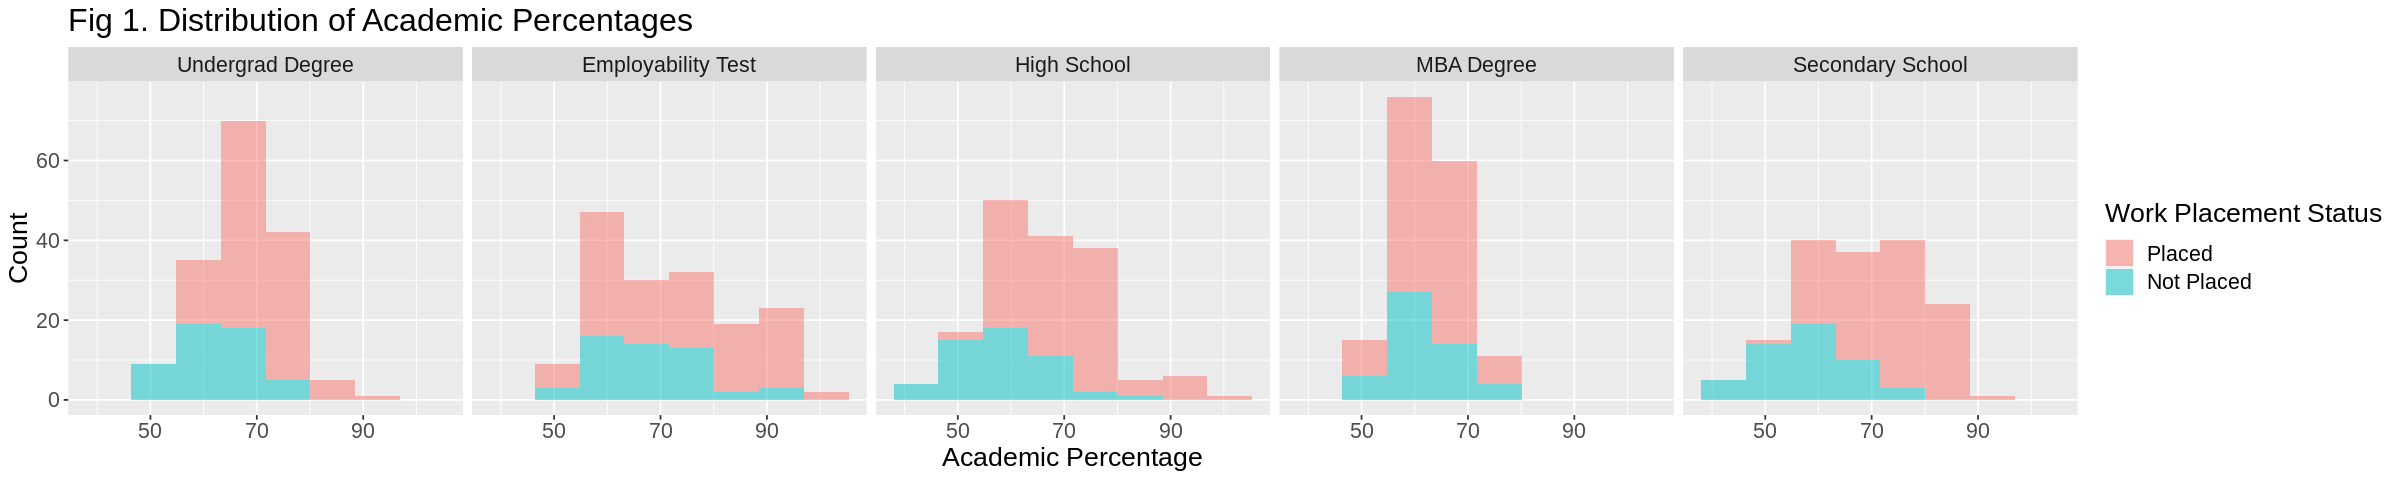

In [5]:
options(repr.plot.width = 20, repr.plot.height = 4)

# adjust data format so that facet_grid can be applied
data_plot <- data_train %>%
    select(status, ssc_p, hsc_p, degree_p, mba_p, etest_p) %>%
    pivot_longer(cols = ssc_p:etest_p,
                 names_to = "degree_type",
                 values_to = "gpa_p")

gpa_labels <- c(ssc_p = "Secondary School", 
                hsc_p = "High School", 
                degree_p = "Undergrad Degree",
                mba_p = "MBA Degree", 
                etest_p = "Employability Test")

# create histograms to show distributions of predictors
distribution_predictors <- ggplot(data_plot, aes(x = gpa_p, fill = status)) +
    geom_histogram(bins = 8, alpha = 0.5) + 
    labs(x = "Academic Percentage", y = "Count", fill = "Work Placement Status") +
    facet_grid(. ~ degree_type, labeller = labeller(degree_type = gpa_labels)) + 
    ggtitle("Fig 1. Distribution of Academic Percentages") +
    theme(text = element_text(size = 16))
distribution_predictors

## III. Methods
### *Selecting Relevant Predictors*
We start by finding the relevant predictors from the following list of pontential predictors: secondary school, high school, undergrad degree, MBA degree, and employability test percentages. For an initial check of relevancy, we paired our predictors in all possible combinations (e.g. hsc_p & degree_p, etc.) and created a scatterplot each time. A sample scatterplot from this process is provided below.

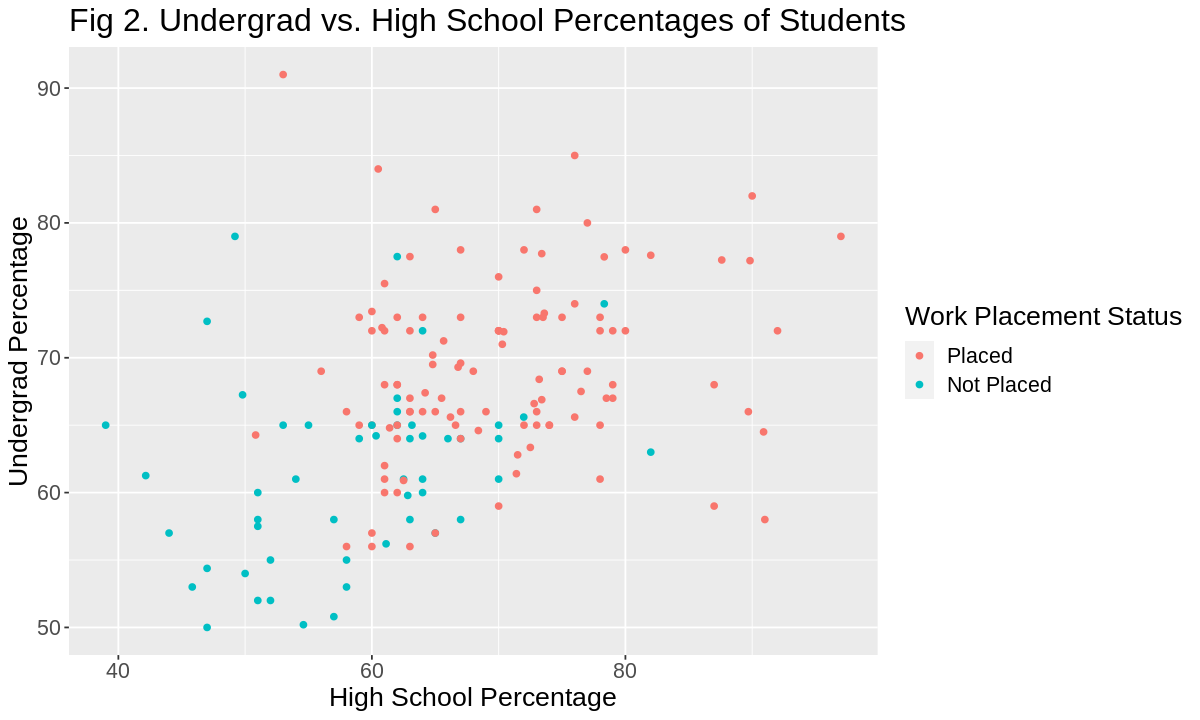

In [6]:
options(repr.plot.width = 10, repr.plot.height = 6)

# create a sample scatterplot 
scatterplot <- ggplot(data_train, aes(x = hsc_p, y = degree_p, color = status)) +
    geom_point() +
    labs(color = "Work Placement Status") +
    xlab("High School Percentage") +
    ylab("Undergrad Percentage") +
    ggtitle("Fig 2. Undergrad vs. High School Percentages of Students") +
    theme(text = element_text(size = 16))
scatterplot

In all scatterplots, we observe rather distinct groups for the two levels of our target variable. To get a better sense of what predictors are relevant, we use the Forward Selection algorithm provided in the DSCI 100 textbook.  

In [7]:
# determining relevant predictors for analysis using the forward selection algorithm
placement_subset <- data_train %>% 
  select(status, 
         ssc_p, 
         hsc_p, 
         degree_p, 
         mba_p, 
         etest_p)

names <- colnames(placement_subset %>% select(-status))

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")

# create a 5-fold cross-validation object
placement_vfold <- vfold_cv(placement_subset, v = 5, strata = status)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("status", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        placement_recipe <- recipe(as.formula(model_string), 
                                data = placement_subset) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() %>%
          add_recipe(placement_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = placement_vfold, grid = 10) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>%
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,status ~ ssc_p,0.8080882
2,status ~ ssc_p+hsc_p,0.8514706
3,status ~ ssc_p+hsc_p+mba_p,0.8334559
4,status ~ ssc_p+hsc_p+mba_p+degree_p,0.8459559
5,status ~ ssc_p+hsc_p+mba_p+degree_p+etest_p,0.8213235


Starting with ssc_p as our only predictor and an initial accuracy of 80.8%, we observe that adding hsc_p and degree_p increased the model accuracy while adding mba_p and etest_p decreased the model accuracy. Using these numerical results along with the visual confirmation from our scatterplots, we choose to proceed with the scc_p, hsc_p, and degree_p variables as our final predictors. 

### *Tuning Model Parameter*
We now perform cross-validation to determine the ideal K-parameter for training our model.

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
5,accuracy,binary,0.8393382,5,0.03201169,Model05


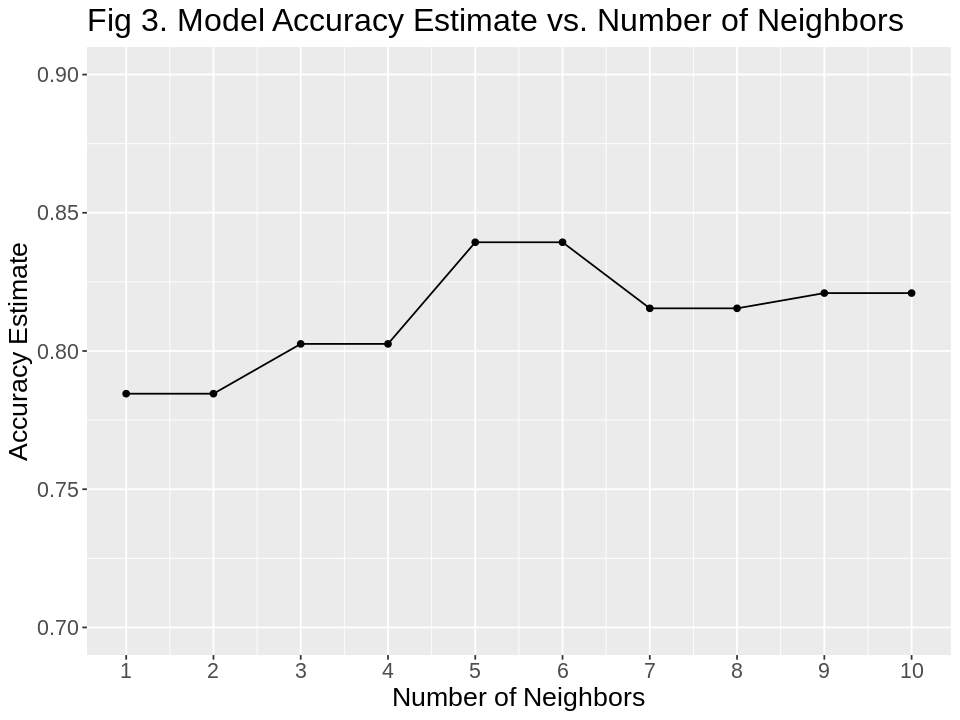

In [8]:
# perform cross-validation
tuning_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

model_recipe <- recipe(status ~ ssc_p + degree_p + mba_p, data = data_train) 

data_vfold <- vfold_cv(data_train, v = 5, strata = status)

k_vals <- tibble(neighbors = seq(1,10))

vfold_metrics <- workflow() %>%
    add_recipe(model_recipe) %>%
    add_model(tuning_spec) %>%
    tune_grid(resamples = data_vfold, grid = k_vals) %>%
    collect_metrics() %>%
    filter(.metric == "accuracy")

# extract ideal K parameter value 
k_best <- vfold_metrics %>%
    arrange(desc(mean)) %>%
    slice(1)

# make a plot of model accuracy estimate vs. K value
options(repr.plot.width = 8, repr.plot.height = 6)
k_plot <- ggplot(vfold_metrics, aes(x = neighbors, y = mean)) +
    geom_point() + 
    geom_line() + 
    labs(x = "Number of Neighbors", y = "Accuracy Estimate") + 
    scale_x_continuous(breaks = seq(0, 10, by = 1)) + 
    scale_y_continuous(limits = c(0.7, 0.9)) +
    ggtitle("Fig 3. Model Accuracy Estimate vs. Number of Neighbors") +
    theme(text = element_text(size = 16))

k_best
k_plot

Using the plot of model accuracy estimate vs. K value, we observe optimal accuracy at K = 5, which is followed by little change in accuracy for larger values of K. Thus, we choose K = 5 to train our model.

### *Training Model*

Now that we have selected our predictors and tuned our K parameter, we train our model using our training data.

In [9]:
# get optimal K value
k_val <- k_best %>% pull(neighbors)

model_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_val) %>%
    set_engine("kknn") %>%
    set_mode("classification")

# train model
model_fit <- workflow() %>%
    add_recipe(model_recipe) %>%
    add_model(model_spec) %>%
    fit(data_train)

model_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~k_val,     kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1790123
Best kernel: rectangular
Best k: 5

## IV. Results

At last, we use our model to predict the labels of our test data. By comparing our predictions against the true labels, we  evaluate our model's accuracy and then create the corresponding confusion matrix.

In [56]:
# make predictions using test data
model_preds <- model_fit %>%
    predict(data_test) %>%
    bind_cols(data_test)

# evaluate accuracy of model
model_metrics <- model_preds %>%
    metrics(truth = status, estimate = .pred_class) %>%
    filter(.metric == "accuracy")

# make confusion matrix
conf_matrix <- model_preds %>% 
    conf_mat(truth = status, estimate = .pred_class) 

model_metrics 
conf_matrix

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8490566


            Truth
Prediction   Placed Not Placed
  Placed         34          5
  Not Placed      3         11

From the metrics table, we observe that our model has a rather high accuracy of 85%. From the confusion matrix, we  observe that our model has a higher tendency of falsely predicting a student as Placed rather than Not Placed. Based on these accuracy results, it appears that we can indeed predict work placement status using a student's secondary school, high school, and undergraduate degree percentages, which answers our original research question! 

## V. Discussion

From our preliminary exploration, we observed that students appeared in distinct groups relative to their work placement status. The group of Placed students often had higher academic averages than the group of Not Placed students. These observations led us to expect that work placement status could indeed be predicted by academic percentages, which we have now confirmed using our model's accuracy results. Furthermore, this result also matches the findings in available literature. As an example, according to CNBC's Ruth Umoh, many employers currently believe that a strong GPA suggests that a candidate will be able to handle work pressure [2]. This indicates that employers would be more likely to hire students with higher GPAs, as similarly suggested by our model .

Nonetheless, it is also important to remember that other factors may also get considered when hiring a student. For example, as Peter A. Gudmundsson from U.S. News mentions, companies nowdays are trying to put more emphasis on the experiences of the candidate rather than solely focusing on their academic performance [3]. This suggests that our model may not be able to make accurate predictions in the future as more companies begin to prioritize one's experiences over  their academic percentages. As a result, we note than our model should ideally be used for students who are currently trying to assess their potential of being hired based on their academic percentages. We believe that the predictions of our model for such students will be impactful since it will inform them on whether they should maintain or change their study habits in order to improve their academic percentages for a work placement.

## VI. Future Questions

As for future investigations, it will be interesting to see whether our results apply to other countries. We acknowledge that our dataset only contains information on Indian students, so our results may not apply to students from other regions. By conducting this investigation with datasets from different countries, we will see whether work placement status can/cannot be predicted from academic percentages in other regions.

## VII. References

1) https://www.kaggle.com/datasets/benroshan/factors-affecting-campus-placement

2) https://www.cnbc.com/2018/07/31/when-to-include-your-gpa-on-your-resume.html?fbclid=IwAR3yt4ZyyChJ7-JXRXp0BAl73vzxna88mPlY1zw5cELOu_w7Him_-CD5_fQ

3) https://money.usnews.com/money/blogs/outside-voices-careers/articles/does-gpa-matter-when-job-searching?fbclid=IwAR2JenJbYjlaueg28-3bQk-oEAk9BGr_nEQ6ofWeUchiPMlBFL3YCH5HuGU